# SEC Report 8-K Overview

Date: 2022-02-28  
Author: Jason Beach  
Categories: Data_Science
Tags: nlp, xbrl, finance

<!--eofm-->

The following code downloads, searches, and analyzes the 8-K filings from a sampling of banks.  Emphasis is placed on extracting financial tables and parsing them for specific accounts.

### Prepare environment

Configure the appropriate modules.  Using a vm with a kernel can help in managing dependencies.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
import re
from rapidfuzz import process, fuzz

In [3]:
import requests
from bs4 import BeautifulSoup

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
root = Path('/home/jovyan/NOTEBOOK_PUBLIC')
libs = root / 'python_modules'

In [6]:
libs_downloader = libs / 'sec-edgar-downloader'
libs_extract = libs / 'sec-edgar-extract'
libs_workflow = libs / 'Prj-sec_workflows'

<br>

Changes to these files can be used, immediately - no need to reload!

In [7]:
os.chdir(libs_downloader)
from sec_edgar_downloader import Downloader
from sec_edgar_downloader import UrlComponent as uc
from sec_edgar_downloader import FilingStorage as fs
os.chdir(root)

In [8]:
os.chdir(libs_extract)
from sec_edgar_extractor.extract import Extractor, Doc
from sec_edgar_extractor import utils as ex_utils
os.chdir(root)

In [9]:
os.chdir(libs_workflow )
from sec_workflows import utils as wf_utils
os.chdir(root)

<br>
<br>

## Quickstart

### Setup the workspace

Start with firms of interest and initialize them with the `Firm` class.  Each is populated with the current SEC EDGAR detailed information.

In [10]:
# banks ordered by total assets
us_banks = [
    ('American Express Company','AXP'),
    ('Capital One Financial Corporation','COF'),
    ('Fifth Third Bancorp','FITB'),
    ('HSBC Holdings PLC','HSBC'),
    ('Huntington Bancshares Incorporated','HBAN'),
    ('Keycorp','KEY'),
    ('Mitsubishi Ufj Financial Group, Inc.','MUFG'),
    ('Morgan Stanley','MS'),
    ('Toronto-Dominion Bank, The','TD'),
    ('JPMorgan Chase','JPM'),
    ('Citigroup Inc','C'),
    ('Wells Fargo','WFC'),
    ('Bank of America','BAC'),
    ('US Bankcorp', 'USB'),
    ('PNC Bank', 'PNC'),
    ('Goldman Sachs', 'GS'),
    ('Truist Financial Corporation', 'TFC'),
    ('Ally Financial Inc', 'ALLY'),
    ('Citizens Financial Group', 'CFG'),
    #('USAA Federal Savings Bank',''),
    ('City National Bank','CYN'),
    ('BankUnited','BKU')
]

In [10]:
foreign_banks = [
    ('Baco Santandar, S.A.','SAN'),
    ('Bank of Montreal','BMO'),
    ('Royal Bank of Canada','RY'),
    ('China Investment Corporation',None),
]

In [10]:
midsize_holding = [
    ('Lauritzen Corporation', ''),
    ('F.N.B. Corporation', ''),
    ('Bank of New York Mellon Corporation', ''),
    ('Old National Bancorp', ''),
    ('Trustmark Corporation', ''),
    ('BOK Financial Corporation', ''),
    ('Valley National Bancorp', ''),
    ('Empress Juan Yarur Spa', ''),
    ('Bessemer Group, Incorporated', ''),
    ('State Stree Corporation', ''),
    ('Deutsche Bank Aktiengesellshaft', ''),
    ('Commercial Incorporated', ''),
    ('Southstate Corporation', ''),
    ('M&T Bank Corporation', ''),
    ('UMB Financial Corporation', ''),
    ('Wintrust Financial Corporation', ''),
    ('Associated Banc-Corp', ''),
    ('Macy\'s Inc', '')
]

In [ ]:
midsize_banks = [
    ('First National Bank of Omaha', ''),
    ('First National Bank of Pennsylvania', ''),
    ('Zions Bancorporation, National Association', ''),
    ('BNY Mellon, National Association', ''),
    ('Old National Bank', ''),
    ('Trustmark National Bank', ''),
    ('BOKF, National Association', ''),
    ('Valley National Bank', ''),
    ('City National Bank of Florida', ''),
]

<br>
Just test with a few banks to keep things managable.

In [11]:
#targets = ['USB','PNC','WFC','TFC','CFG','ALLY','C','JPM','GS']
banks = [bank for bank in us_banks]    # if bank[1] in targets]
bank_list = [uc.Firm(ticker=bank[1]) for bank in banks if bank[1] != None]

In [ ]:
#for midsize holding
banks = [bank for bank in midsize_holding]    # if bank[1] in targets]
midsize_bank_list = [uc.Firm(firm_name=bank[0]) for bank in banks if bank[1] != None]

In [12]:
#assert len(bank_list) == len(banks)
bank_list[0].get_info()['ticker']
[f"{bank.get_info()['name']},    {bank.get_info()['ticker']}: {bank.get_info()['cik']}" for bank in bank_list]

['AMERICAN EXPRESS CO,    AXP: 4962',
 'CAPITAL ONE FINANCIAL CORP,    COF: 927628',
 'FIFTH THIRD BANCORP,    FITB: 35527',
 'HSBC HOLDINGS PLC,    HSBC: 1089113',
 'HUNTINGTON BANCSHARES INC /MD/,    HBAN: 49196',
 'KEYCORP /NEW/,    KEY: 91576',
 'MITSUBISHI UFJ FINANCIAL GROUP INC,    MUFG: 67088',
 'MORGAN STANLEY,    MS: 895421',
 'TORONTO DOMINION BANK,    TD: 947263',
 'JPMORGAN CHASE & CO,    JPM: 19617',
 'CITIGROUP INC,    C: 831001',
 'WELLS FARGO & COMPANY/MN,    WFC: 72971',
 'BANK OF AMERICA CORP /DE/,    BAC: 70858',
 'US BANCORP \\DE\\,    USB: 36104',
 'PNC FINANCIAL SERVICES GROUP, INC.,    PNC: 713676',
 'GOLDMAN SACHS GROUP INC,    GS: 886982',
 'TRUIST FINANCIAL CORP,    TFC: 92230',
 'Ally Financial Inc.,    ALLY: 40729',
 'CITIZENS FINANCIAL GROUP INC/RI,    CFG: 759944',
 'Cyngn Inc.,    CYN: 1874097',
 'BankUnited, Inc.,    BKU: 1504008']

<br>

Initialize the Downloader with a location on the file system.  If the location was previously used, then a binary of the Downloader's filing storage will be loaded.

In [13]:
# Initialize a downloader instance. If no argument is passed
# to the constructor, the package will download filings to
# the current working directory.
dl = Downloader("/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/DownLoad")

log: updated filing storage
log: created file for storing Filings list


<br>

Check the storage of current Filing records.

In [14]:
dl.filing_storage

FilingStorage with 0 filing records

<br>

### Explore filing documents

There are two primary workflows for getting the documents from SEC EDGAR.

The new, first method involves getting and managing filing records within the `filing_storage`.  You can query and filter them to choose what documents to get.  Then, you can download them using the selected urls:

* `dl.get_urls()` - search urls on edgar
* `dl.filing_storage.get_dataframe()` - query urls by filtering metadata
* `urls` - stage queried urls
* `dl.get_by_url()` - download documents of staged urls



<br>

__New method__

The Firm class variables hold cik for all firm objects created.  This prevents redundancy when creating Firms.

In [15]:
ciks = [str(cik) for cik in uc.Firm.get_ciks()]
print(ciks)

['36104', '759944', '1504008', '72971', '927628', '67088', '831001', '40729', '19617', '49196', '1874097', '91576', '895421', '947263', '886982', '35527', '92230', '70858', '713676', '1089113', '4962']


<br>

Get the Filing information, first, then choose the documents to download.

In [ ]:
#get urls and download the docs
for bank in bank_list:
    TICKER = bank.get_info()['ticker']
    urls = dl.get_metadata("8-K",
                       TICKER, 
                       after="2022-01-01") # note: after and before strings must be in the form "YYYY-MM-DD"    

In [18]:
#default arg is for `file` level
dl.filing_storage.get_dataframe()

,short_cik,accession_number,file_type,file_date,report_date,filing_details_filename,doc_types
0,4962,0000004962-22-000032,8-K,2022-05-16,2022-05-16,"(None,)","[nan, XML, EX-101.SCH, EX-101.LAB, 8-K, EX-101..."
1,4962,0000004962-22-000030,8-K,2022-05-04,2022-05-03,"(None,)","[nan, XML, EX-101.SCH, EX-101.LAB, 8-K, EX-101..."
2,4962,0000004962-22-000029,8-K,2022-05-03,2022-05-03,"(None,)","[nan, XML, GRAPHIC, EX-5, EX-101.SCH, EX-101.L..."
3,4962,0000004962-22-000025,8-K,2022-04-22,2022-04-22,"(None,)","[nan, XML, GRAPHIC, EX-99.1, EX-101.SCH, EX-10..."
4,4962,0000004962-22-000021,8-K,2022-04-15,2022-04-15,"(None,)","[nan, XML, EX-101.SCH, EX-101.LAB, 8-K, EX-101..."
...,...,...,...,...,...,...,...
210,1874097,0001213900-22-000964,8-K,2022-01-06,2022-01-01,"(None,)","[nan, EX-10.1, XML, EX-101.SCH, EX-101.LAB, 8-..."
211,1504008,0001504008-22-000018,8-K,2022-05-03,2022-05-03,"(None,)","[nan, XML, EX-101.SCH, EX-101.DEF, EX-101.LAB,..."
212,1504008,0001504008-22-000015,8-K,2022-04-21,2022-04-21,"(None,)","[nan, XML, GRAPHIC, EX-99.1, EX-101.SCH, EX-10..."
213,1504008,0001504008-22-000006,8-K,2022-02-02,2022-02-02,"(None,)","[nan, XML, EX-101.SCH, EX-101.DEF, EX-101.LAB,..."


<br>

The storage should be updated if new urls are queried.

In [19]:
dl.filing_storage

FilingStorage with 215 filing records

<br>

_Note:_ If the storage is somehow corrupted, but you have a large number of documents previously downloaded, then you can use the `sync_with_filesystem()` method to ensure all downloaded documents are managed.

In [20]:
dl.filing_storage.sync_with_filesystem()

log: updated filing storage
There were 3349 document FS_Location synced with filesystem


<br>

Once Documents are downloaded, then the records are updated with the FileSystem_Location.

In [21]:
df = dl.filing_storage.get_dataframe(mode='document')
df[df.FS_Location!=''].head(1)

,Seq,Description,Document,Type,Size,URL,Extension,FS_Location,short_cik,accession_number,file_type,file_date,report_date,yr-month
0,1.0,8-K,axp-20220516.htm iXBRL,8-K,72218,/Archives/edgar/data/4962/000000496222000032/a...,htm,None,4962,0000004962-22-000032,8-K,2022-05-16,2022-05-16,2022-5


In [16]:
#{(k,v) for (k,v) in dl.filing_storage._FilingStorage__FilingSet.items()}
#[v for v in dl.filing_storage._FilingStorage__FilingSet.values()]
#list(dl.filing_storage._FilingStorage__FilingSet.items())[0]

<br>

Let's look around our Filing and Document records for the different ways to query and filter.  Each File is stored with a hash of the key: 
`<cik>|<accession_number>`.  We can access the Filing record that way, also.

In [22]:
dl.filing_storage.get_record(0)

('4962|0000004962-22-000032',
 {'short_cik': '4962', 'accession_number': 0000004962-22-000032, 'file_type': '8-K', 'file_date': datetime.datetime(2022, 5, 16, 0, 0), 'report_date': datetime.datetime(2022, 5, 16, 0, 0), 'filing_details_filename': (None,), 'doc_types': [nan, 'XML', 'EX-101.SCH', 'EX-101.LAB', '8-K', 'EX-101.PRE']})

In [23]:
dl.filing_storage.get_record('72971|0001193125-22-083978')

{'short_cik': '72971', 'accession_number': 0001193125-22-083978, 'file_type': '8-K', 'file_date': datetime.datetime(2022, 3, 24, 0, 0), 'report_date': datetime.datetime(2022, 3, 24, 0, 0), 'filing_details_filename': (None,), 'doc_types': [nan, 'XML', 'GRAPHIC', 'EX-4.1', 'EX-101.SCH', 'EX-101.DEF', 'EX-101.LAB', '8-K', 'EX-5.1', 'EX-101.PRE']}

<br>

Lets get all Filing records and look in-depth, at one.  The `document_metadata_list` keeps records of all the Filing's Documents.

In [24]:
tmp1 = list(dl.filing_storage.get_all_records().items())[0]
tmp1

('4962|0000004962-22-000032',
 {'short_cik': '4962', 'accession_number': 0000004962-22-000032, 'file_type': '8-K', 'file_date': datetime.datetime(2022, 5, 16, 0, 0), 'report_date': datetime.datetime(2022, 5, 16, 0, 0), 'filing_details_filename': (None,), 'doc_types': [nan, 'XML', 'EX-101.SCH', 'EX-101.LAB', '8-K', 'EX-101.PRE']})

In [25]:
tmp1[1].document_metadata_list[:3]

[DocumentMetadata(Seq=1.0, Description='8-K', Document='axp-20220516.htm  iXBRL', Type='8-K', Size=72218, URL='/Archives/edgar/data/4962/000000496222000032/axp-20220516.htm', Extension='htm', FS_Location=None),
 DocumentMetadata(Seq=nan, Description='Complete submission text file', Document='0000004962-22-000032.txt', Type=nan, Size=210412, URL='/Archives/edgar/data/4962/000000496222000032/0000004962-22-000032.txt', Extension='txt', FS_Location=None),
 DocumentMetadata(Seq=2.0, Description='XBRL TAXONOMY EXTENSION SCHEMA DOCUMENT', Document='axp-20220516.xsd', Type='EX-101.SCH', Size=1992, URL='/Archives/edgar/data/4962/000000496222000032/axp-20220516.xsd', Extension='xsd', FS_Location=None)]

<br>

By using a pandas DataFrame, we can more effectively query the Filings.  The user can transform the storage to a DataFrame at the Filing or the Document level.  This negates the need for complex nested queries.

In [26]:
df = dl.filing_storage.get_dataframe()
sel1 = df[(df['short_cik'].isin(ciks)) & (df['file_type'] == '8-K')]
mask = sel1['doc_types'].apply(lambda x: 'EX-99.1' in x)   #TODO: mod to subset on '99'
sel2 = sel1[mask]
sel2.shape

(73, 7)

In [27]:
list(dl.filing_storage.get_all_records().values())[0].get_document_record_list()[0]

{'Seq': 1.0,
 'Description': '8-K',
 'Document': 'axp-20220516.htm  iXBRL',
 'Type': '8-K',
 'Size': 72218,
 'URL': '/Archives/edgar/data/4962/000000496222000032/axp-20220516.htm',
 'Extension': 'htm',
 'FS_Location': None,
 'short_cik': '4962',
 'accession_number': 0000004962-22-000032,
 'file_type': '8-K',
 'file_date': datetime.datetime(2022, 5, 16, 0, 0),
 'report_date': datetime.datetime(2022, 5, 16, 0, 0),
 'yr-month': '2022-5'}

<br>

### Download the documents

<br>

__New method__

Once you select the Documents of interest, then you can stage them as a list of indices prepared for downloading.  Remember that each Document's `FS_Location` should be updated with the path of the downloaded Document file.

In [28]:
df = dl.filing_storage.get_dataframe(mode='document')
df.shape

(3349, 14)

In [39]:
sel1 = df[(df['short_cik'].isin(ciks)) & (df['file_type'] == '8-K') & (df['FS_Location'].isnull())]       # pd does not like (df['FS_Location'] == None)]
def check(row):
    if type(row.Type) == str and ('EX-99.1' in row.Type or 'EX-99.2' in row.Type or 'EX-99.3' in row.Type):
        return True
    else:
        return False
mask = sel1.apply(check, axis=1)
sel2 = sel1[mask]
sel2.shape

(128, 14)

In [40]:
lst_of_idx = sel2.index.tolist()
staged = dl.filing_storage.get_document_in_record( lst_of_idx )

In [ ]:
updated = dl.get_documents_from_url_list(staged)

In [44]:
len(updated['new']), len(updated['previous']), len(updated['fail'])

(128, 0, 0)

Check that the updated documents are also updated in the `filing_storage`.

In [29]:
#[doc for doc in dl.filing_storage.get_all_records(mode='document').values() if doc.FS_Location != ''][:3]

<br>

__Original method__

This is the original, direct method of querying for documents.  There is not quite as much flexibility for exploration, but if you already know what you're after, then it is the most direct apporach.

* `dl.get_metadata()` - get the filing metadata and associated urls
* `dl.get()` - get the documents

<br>

### TODO: Information Extraction  


In [15]:
df = dl.filing_storage.get_dataframe(mode='document')
df.shape

(11007, 13)

In [16]:
ciks = [str(cik) for cik in uc.Firm.get_ciks()]
print(ciks)

['36104', '759944', '1504008', '72971', '927628', '67088', '831001', '40729', '19617', '49196', '1874097', '91576', '895421', '947263', '886982', '35527', '92230', '70858', '713676', '1089113', '4962']


In [18]:
sel1 = df[(df['short_cik'].isin(ciks)) & (df['file_type'] == '8-K') & (df['FS_Location'] != '')]
sel1.shape

(194, 13)

In [23]:
sel1.head(3)

,Seq,Description,Document,Type,Size,URL,Extension,FS_Location,short_cik,accession_number,file_type,file_date,yr-month
2875,2.0,"PRESS RELEASE DATED JANUARY 24, 2022",d293492dex991.htm,EX-99.1,19336,/Archives/edgar/data/72971/000119312522016577/...,htm,/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/TES...,72971,0001193125-22-016577,8-K,2022-01-25,2022-1
2876,3.0,"PRESS RELEASE DATED JANUARY 25, 2022",d293492dex992.htm,EX-99.2,12879,/Archives/edgar/data/72971/000119312522016577/...,htm,/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/TES...,72971,0001193125-22-016577,8-K,2022-01-25,2022-1
2885,2.0,EX-99.1,wfc4qer01-14x22ex991xrelea.htm,EX-99.1,415747,/Archives/edgar/data/72971/000007297122000003/...,htm,/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/TES...,72971,0000072971-22-000003,8-K,2022-01-14,2022-1


In [50]:
docs = sel1[['short_cik','Type','FS_Location']].to_dict('records')[:3]

In [57]:
config_file = libs_extract / 'config'/ 'Firm_Account_Info.csv'
config_file.exists()

True

In [64]:
ex = Extractor(file_path = config_file, 
               save_intermediate_files = False
              )

In [65]:
result = {}
for doc in docs:
    ticker = [bank.get_info()['ticker'] for bank in bank_list if str(bank.get_info()['cik']) == doc['short_cik']][0]
    html_file = doc['FS_Location']
    desc = doc['Type']
    doc = Doc(Description=desc, FS_Location=html_file)

    rec = ex.execute_extract_process(doc=doc, ticker=ticker)
    result[ticker] = rec

Directory: d293492dex991.htm
Directory: d293492dex992.htm
Account: ACL
0
log: execution took: 0.084sec
Exception: list index out of range
Account: PCL
0
log: execution took: 0.017sec
Exception: list index out of range
Account: Loans
0
log: execution took: 0.011sec
Exception: list index out of range
Account: ACLpctLoan
0
log: execution took: 0.015sec
Exception: list index out of range
Account: NetChargeOffs
0
log: execution took: 0.014sec
Exception: list index out of range
Directory: wfc4qer01-14x22ex991xrelea.htm


In [ ]:
staged = sel2.to_dict('records')
dl.get_documents_from_url_list('8-K', staged)
idx = staged_urls[0].index()
df = dl.filing_storage.get_dataframe(mode='document')
loc = df.loc[idx]['FS_Location']
loc

Cannot `load_documents()` because they will not fit into memory.  This output is from earlier runs with fewer documents.

Quick search does not work very well.  Use better tools, such as the `search_docs_for_terms()` function.

<br>
<br>
<br>

## Data Exploration

### Report graph

`utils.create_report(report_type, db, output_path)`

In [12]:
file_path

PosixPath('python_modules/Prj-sec_workflows/output.csv')

In [14]:
file_path = Path() / 'python_modules' / 'Prj-sec_workflows' / 'archive' / 'output.csv'
df = pd.read_csv(file_path)
df.shape

(124, 13)

In [24]:
df['cik'] = df.cik.astype(str)
df['cik'].value_counts()

713676    18
40729     17
831001    14
19617     14
886982    12
92230     12
36104     12
72971     11
759944     9
91576      5
Name: cik, dtype: int64

In [35]:
df['dt_filed'] = pd.to_datetime(df.filed)
df.sort_values(by=['cik','dt_filed'], inplace=True, ascending=False)
df.head(10)

,cik,accn,Loans,ACLpctLoan,ALLL,PCL,ACL,ChargeOffs,fy,fp,form,end,filed,dt_filed
123,92230,0000092230-22-000048,294248,NaN,NaN,NaN,4423.0,NaN,2022.0,Q1,8-K/EX-99.2,NaN,2022-04-19 00:00:00.000000,2022-04-19
5,92230,0000092230-22-000008,289513,NaN,NaN,-813.0,NaN,NaN,2021.0,FY,10-K,2021-12-31,2022-02-23 00:00:00.000000,2022-02-23
122,92230,0000092230-22-000003,294325,NaN,NaN,-813.0,NaN,NaN,2021.0,FY,8-K/EX-99.2,NaN,2022-01-18 00:00:00.000000,2022-01-18
13,92230,0000092230-21-000078,285522,NaN,NaN,-324.0,NaN,NaN,2021.0,Q3,10-Q,2021-09-30,2021-11-02 00:00:00.000000,2021-11-02
121,92230,0000092230-21-000071,290655,NaN,NaN,-710.0,NaN,NaN,2021.0,Q3,8-K/EX-99.2,NaN,2021-10-15 00:00:00.000000,2021-10-15
19,92230,0000092230-21-000063,286485,NaN,NaN,-434.0,NaN,NaN,2021.0,Q2,10-Q,2021-06-30,2021-08-06 00:00:00.000000,2021-08-06
120,92230,0000092230-21-000059,289494,NaN,NaN,-386.0,NaN,NaN,2021.0,Q2,8-K/EX-99.2,NaN,2021-07-15 00:00:00.000000,2021-07-15
34,92230,0000092230-21-000044,291511,NaN,NaN,48.0,NaN,NaN,2021.0,Q1,10-Q,2021-03-31,2021-05-03 00:00:00.000000,2021-05-03
119,92230,0000092230-21-000038,297179,NaN,NaN,NaN,NaN,NaN,2021.0,Q1,8-K/EX-99.2,NaN,2021-04-15 00:00:00.000000,2021-04-15
38,92230,0000092230-21-000032,299734,NaN,NaN,2335.0,NaN,NaN,2020.0,FY,10-K,2020-12-31,2021-02-24 00:00:00.000000,2021-02-24


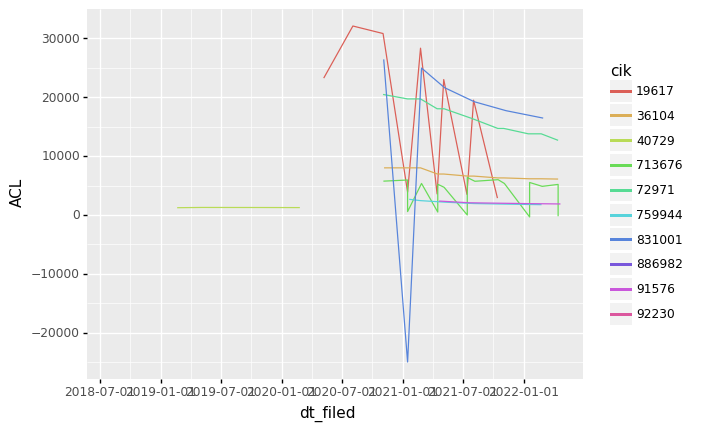

<ggplot: (8794186506973)>

In [37]:
plt = p9.ggplot(data=df,
                mapping=p9.aes(x='dt_filed',
                y='ACL',
                color='cik')
                ) + p9.geom_line()
plt

In [45]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

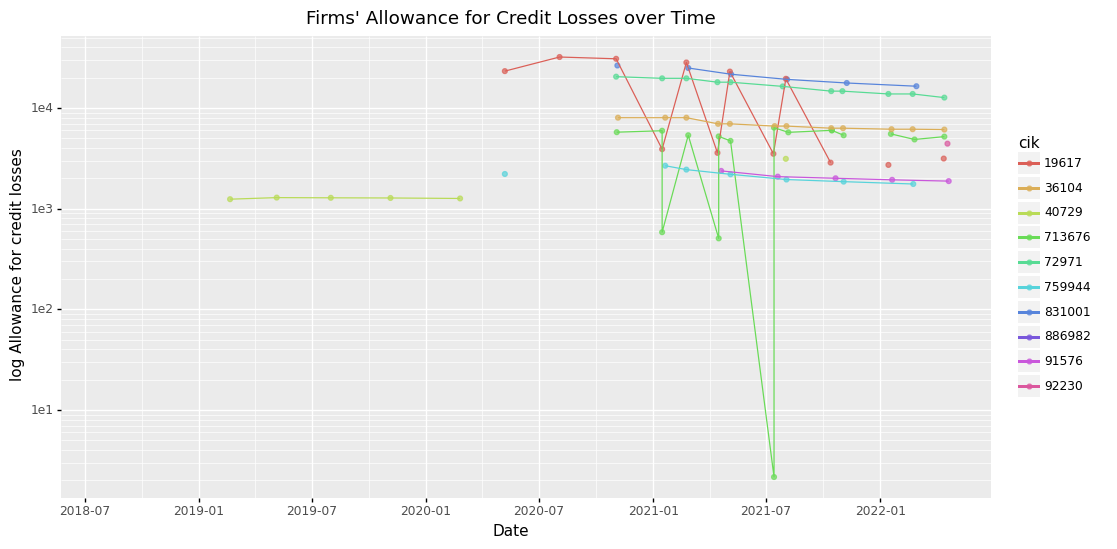

<ggplot: (8794186267156)>

In [47]:
(ggplot(aes(x='dt_filed', y='ACL'), df)
 + geom_point(aes(color='cik'), alpha=0.7) 
 + geom_line(aes(color='cik')) 
 + scale_x_datetime(labels=date_format('%Y-%m')) 
 + scale_y_log10()
 + labs(y='log Allowance for credit losses', x='Date', title="Firms' Allowance for Credit Losses over Time")
 + theme(figure_size=(12, 6))
)

In [53]:
type(df['dt_filed'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
pivot = np.round(pd.pivot_table(df[df['dt_filed']>'2021-12-31'], values='ACL', 
                                index='cik', 
                                columns='fp', 
                                aggfunc=np.mean),2)
pivot

fp,FY,Q1
cik,,
19617,2720.0,3146.0
36104,6155.0,6105.0
713676,3357.0,2494.5
72971,13788.0,12681.0
759944,1758.0,NaN
831001,16455.0,NaN
92230,NaN,4423.0


<br>

### Value-Added investigation

The `sec-edgar-extractor` project extracts information from the unstructured 8-Ks, rather than waiting for the structured 10-K/-Q data.  It would be good to know what the outcome is of this investment: does extracting from 8-Ks really add business value.  Let's get the expected number of days between 8-K and the subsequent 10-K/-Q to make this determination.

<br>

Get the dataframe and filter for the downloaded 8-K (exhibits 99.1, 99.2, 99.3) documents.

In [107]:
df = dl.filing_storage.get_dataframe(mode='document')
df.shape

(5555, 13)

In [109]:
tmp = df[df['FS_Location'] != '']
df_8k = tmp.drop_duplicates(subset=['accession_number'])
df_8k.shape

(114, 13)

<br>

Get the dataframe of 10-Q Filings from `sec-edgar-workflows` and prepare columns.

In [113]:
file = 'large_dataset/10q_output.csv'
df_10q = pd.read_csv(file)
df_10q.shape

In [116]:
df_10q['dt_filed'] = pd.to_datetime(df_10q.filed)
df_10q['fp'].value_counts()

FY    43
Q3    41
Q2    31
Q1    27
Name: fp, dtype: int64

In [117]:
def create_qtr(row):
    if row['fp']=='FY': 
        fp = 4
    else:
        fp = str(row['fp']).replace('Q','')
    return str(row['fy']) + '-' + str(fp)

df_10q['yr-qtr'] = df_10q.apply(create_qtr, axis=1)

In [220]:
df_10q['yr-qtr'][:3] 

80    2020-3
63    2020-4
54    2021-1
Name: yr-qtr, dtype: object

In [119]:
df_10q['short_cik'] = df_10q['cik'].astype(str)

<br>

There is no way to distinguish what quarter the 8-Ks earnings reference, without looking in the documents.  Instead, assume that 8-Ks will be submitted before a subsequent 10-Q, then associate that 10-Q's submitted quarter with the 8-K.

In [ ]:
def get_8k_qtr(df8k, df10q):
    """Get the 8-K quarter by referencing the correspoding 10-Qs."""
    #prepare
    df8k['dt_file_date'] = pd.to_datetime(df_8k['file_date'])
    df10q['dt_filed'] = pd.to_datetime(df10q['filed'])
    df8k.sort_values(by=['short_cik','dt_file_date'], inplace=True)
    df10q.sort_values(by=['short_cik','dt_filed'], inplace=True)
    ciks10q = df10q['short_cik'].tolist()
    
    #check each filing
    results = []
    for doc in df8k.to_dict('records'):
        cik = doc['short_cik'] 
        fd = doc['dt_file_date']
        if cik in ciks10q:
            dftmp = df10q[(df10q['short_cik'] == cik) & (df10q['dt_filed'] >= fd)]
            if dftmp.shape[0] > 0:
                item = dftmp.iloc[0]['yr-qtr']
                results.append( item )
            else: results.append( None )
        else: results.append( None )
    df_8k['yr-qtr'] = results    
    return df_8k
    
new_df_8k = get_8k_qtr(df_8k, df_10q)

<br>

Now, merge the 8-K and corresponding 10-Q for the quarter, then find the difference in filing dates.

In [125]:
df_8k.iloc[0]['short_cik'], df_8k.iloc[0]['yr-qtr']

('19617', '2020-4')

In [126]:
df_10q.iloc[0]['cik'], df_8k.iloc[0]['yr-qtr']

(1504008, '2020-4')

In [131]:
df_mrg = pd.merge(df_8k, df_10q,  how='left', left_on=['short_cik','yr-qtr'], right_on = ['short_cik','yr-qtr'])
df_mrg['diff'] = df_mrg['dt_filed'] - df_mrg['file_date']
df_mrg['diff_days'] = df_mrg['diff'].map(lambda x: x.days)
df_mrg2 = df_mrg[df_mrg['diff_days'].isnull()==False]

df_mrg2[['file_date','dt_filed','diff_days']]

,file_date,dt_filed,diff_days
0,2021-01-15,2021-02-23,39.0
1,2021-04-14,2021-05-04,20.0
2,2021-05-18,2021-08-02,76.0
3,2021-07-13,2021-08-02,20.0
4,2021-10-13,2021-11-02,20.0
...,...,...,...
109,2021-06-28,2021-08-06,39.0
110,2021-07-15,2021-08-06,22.0
111,2021-08-17,2021-11-02,77.0
112,2021-10-15,2021-11-02,18.0


<br>

Finally, interrogate the difference distribution by graphing and digging-into outliers.

In [226]:
#basic
diff = df_mrg2['diff_days'].to_list()
print(f"Mean: {np.mean(diff) }")
print(f"Median: {np.median(diff) }")

Mean: 43.49074074074074
Median: 36.0


In [217]:
#outliers
tmp = df_mrg2[df_mrg2['diff_days'] > 50].sort_values(by=['diff_days'], ascending=False)
tmp[['yr-qtr','URL','file_date','filed','diff_days']].head()

,yr-qtr,URL,file_date,filed,diff_days
22,2021-2,/Archives/edgar/data/40729/000004072921000002/...,2021-01-12,2021-08-02 00:00:00.000000,202.0
23,2021-2,/Archives/edgar/data/40729/000119312521014149/...,2021-01-22,2021-08-02 00:00:00.000000,192.0
80,2021-4,/Archives/edgar/data/759944/000075994421000151...,2021-11-04,2022-02-23 00:00:00.000000,111.0
17,2021-4,/Archives/edgar/data/36104/000119312521321060/...,2021-11-05,2022-02-22 00:00:00.000000,109.0
24,2021-2,/Archives/edgar/data/40729/000119312521118498/...,2021-04-16,2021-08-02 00:00:00.000000,108.0


By removing the most-egregious outliers we can make some reasonable claims about the Filings.  The primary conclusion is that: 

> The distribution of times between 8-K and 10-Q Filings is highly skewed, which is typical of arrival-time data.  The median provides a reasonable expectation of a 10-Q being submitted about 36 days after the 8-K earnings statement.  About 20% of all 8-Ks will be filed more than 61 days, or 2 months, before the 10-Q.

In [228]:
diff_no_outlier = diff[:7] + diff[9:]

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [213]:
data = diff
count, bins_count = np.histogram(data, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
print(f"About {1-cdf[2]}% of these 8-Ks")
print(f"will be filed more than {bins_count[2]} days before the 10-Q")

About 0.6759259259259259% of these 8-Ks
will be filed more than 14.4 days before the 10-Q


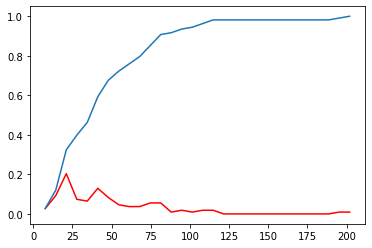

In [214]:
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")

In [215]:
data = diff_no_outlier
count, bins_count = np.histogram(data, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
print(f"About {1-cdf[9]}% of these 8-Ks")
print(f"will be filed more than {bins_count[9]} days before the 10-Q")

About 0.20754716981132082% of these 8-Ks
will be filed more than 61.300000000000004 days before the 10-Q


<br>

Finish with a nice ggplot graph.

In [133]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

/home/jovyan/.local/share/virtualenvs/py310-soU67yXL/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 12'. Pick better value with 'binwidth'.


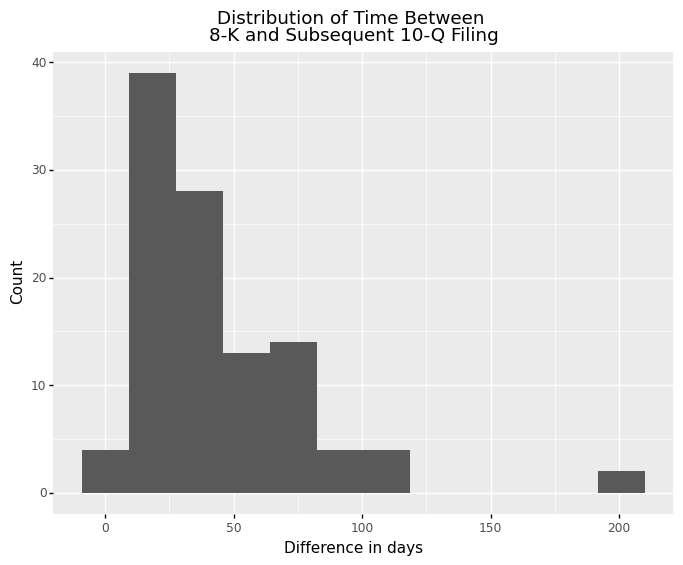

<ggplot: (8755617790028)>

In [146]:
(ggplot(df_mrg2, aes(x='diff_days', y=after_stat('count')))
    + geom_histogram()
    + labs(y='Count', x='Difference in days', title='Distribution of Time Between \n8-K and Subsequent 10-Q Filing', fill='File Type')
    #+ scale_x_log10()
    + theme(figure_size=(8, 6))
)

<br>

### Descriptive statisics (older api)

#### Prepare data

In [24]:
df = pd.DataFrame.from_dict(recs)

In [25]:
#focus on bank CIK
print(df.shape)
ciks = [str(bank.get_info()['cik']) for bank in banks_uniq]
df = df[df['cik'].isin(ciks)]
print(df.shape)

(34746, 8)
(27321, 8)


In [26]:
#TODO: remove duplicates from Downloader
df.drop_duplicates(subset=['cik','accession','doc_type'], inplace=True)
df.shape

(5466, 8)

This is the DataFrame with the lowest level of detail possible.

In [27]:
df_orig = df

#### Primary 8-K purpose

Need to capture the primary reason of the 8-K, 'press release' or something else.  Do this by keeping only one document per filing, with doc 99.1 being kept if it is available.

In [28]:
df['accession'] = df['accession'].astype('category')
df_tmp1 = df[df['doc_type'] == 'EX-99.1'].groupby(['accession']).size().reset_index(name='flag_99.1') 
df_tmp2 = df.groupby(['accession'])['file_size'].sum()
df_tmp1['total_filing_size'] = df_tmp2.values
df = pd.merge(df, df_tmp1, on='accession', how='left')
df[df['flag_99.1']==1].shape

(2484, 10)

In [29]:
df_file = df.drop_duplicates(subset=['cik','accession','yr-month'])

In [30]:
df_file

,cik,ticker,accession,file_type,doc_type,date,yr-month,file_size,flag_99.1,total_filing_size
0,72971,,0001387131-20-003968,8-K,8-K,2020-04-17,2020-4,72057,0,1597105
14,72971,,0001387131-20-003874,8-K,8-K,2020-04-14,2020-4,68374,0,902673
24,72971,,0000072971-20-000230,8-K,8-K,2020-04-14,2020-4,84695,1,18437177
35,72971,,0000072971-22-000003,8-K,8-K,2022-01-14,2022-1,71473,1,12407238
46,72971,,0001193125-22-016577,8-K,8-K,2022-01-25,2022-1,45060,1,486499
...,...,...,...,...,...,...,...,...,...,...
5422,759944,,0000759944-21-000054,8-K,8-K,2021-04-23,2021-4,78901,0,446869
5430,759944,,0001193125-20-245822,8-K,8-K,2020-09-15,2020-9,31516,1,11693802
5439,759944,,0001193125-21-182270,8-K,8-K,2021-06-04,2021-6,31767,0,295194
5446,831001,,0001104659-22-028867,8-K,8-K,2022-03-02,2022-3,42823,1,4659791


In [31]:
df_tmp1 = df_file.groupby(['cik', 'yr-month']).size()#.reset_index(name='total_file_count')
df_tmp2 = df_file[df_file['flag_99.1']>0].groupby(['cik', 'yr-month']).size()#.reset_index(name='99.1_count')

In [32]:
df_tmp1.name = 'total_file_count'
df_tmp2.name = '99.1_count'

In [33]:
df_cik = df_tmp1.to_frame().join(df_tmp2)
df_cik['99.1_count'][np.isnan(df_cik['99.1_count'])] = 0

/tmp/ipykernel_6221/3789130277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cik['99.1_count'][np.isnan(df_cik['99.1_count'])] = 0


In [34]:
df_cik['pct_99.1'] = df_cik['99.1_count'] / df_cik['total_file_count']

In [35]:
df_cik.reset_index(inplace=True)
df_cik['dt'] = pd.to_datetime(df_cik['yr-month'], format='%Y-%m')

In [37]:
cik_tkr = [(str(bank.get_info()['cik']),bank.get_info()['ticker']) for bank in banks_uniq]
df_tkr = pd.DataFrame.from_records(cik_tkr, columns=['cik','ticker'])

In [38]:
df_tmp1['cik'] = df_cik['cik'].astype('str')
df_tkr['cik'] = df_tkr['cik'].astype('str')
df_cik = pd.merge(df_cik, df_tkr, on='cik', how='left')

In [39]:
df_file

,cik,ticker,accession,file_type,doc_type,date,yr-month,file_size,flag_99.1,total_filing_size
0,72971,,0001387131-20-003968,8-K,8-K,2020-04-17,2020-4,72057,0,1597105
14,72971,,0001387131-20-003874,8-K,8-K,2020-04-14,2020-4,68374,0,902673
24,72971,,0000072971-20-000230,8-K,8-K,2020-04-14,2020-4,84695,1,18437177
35,72971,,0000072971-22-000003,8-K,8-K,2022-01-14,2022-1,71473,1,12407238
46,72971,,0001193125-22-016577,8-K,8-K,2022-01-25,2022-1,45060,1,486499
...,...,...,...,...,...,...,...,...,...,...
5422,759944,,0000759944-21-000054,8-K,8-K,2021-04-23,2021-4,78901,0,446869
5430,759944,,0001193125-20-245822,8-K,8-K,2020-09-15,2020-9,31516,1,11693802
5439,759944,,0001193125-21-182270,8-K,8-K,2021-06-04,2021-6,31767,0,295194
5446,831001,,0001104659-22-028867,8-K,8-K,2022-03-02,2022-3,42823,1,4659791


In [40]:
df_cik

,cik,yr-month,total_file_count,99.1_count,pct_99.1,dt,ticker
0,19617,2020-1,5,1.0,0.200000,2020-01-01,JPM
1,19617,2020-10,3,2.0,0.666667,2020-10-01,JPM
2,19617,2020-11,2,0.0,0.000000,2020-11-01,JPM
3,19617,2020-12,2,0.0,0.000000,2020-12-01,JPM
4,19617,2020-2,2,1.0,0.500000,2020-02-01,JPM
...,...,...,...,...,...,...,...
210,92230,2021-4,3,2.0,0.666667,2021-04-01,TFC
211,92230,2021-6,2,1.0,0.500000,2021-06-01,TFC
212,92230,2021-7,1,1.0,1.000000,2021-07-01,TFC
213,92230,2021-8,1,1.0,1.000000,2021-08-01,TFC


In [41]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


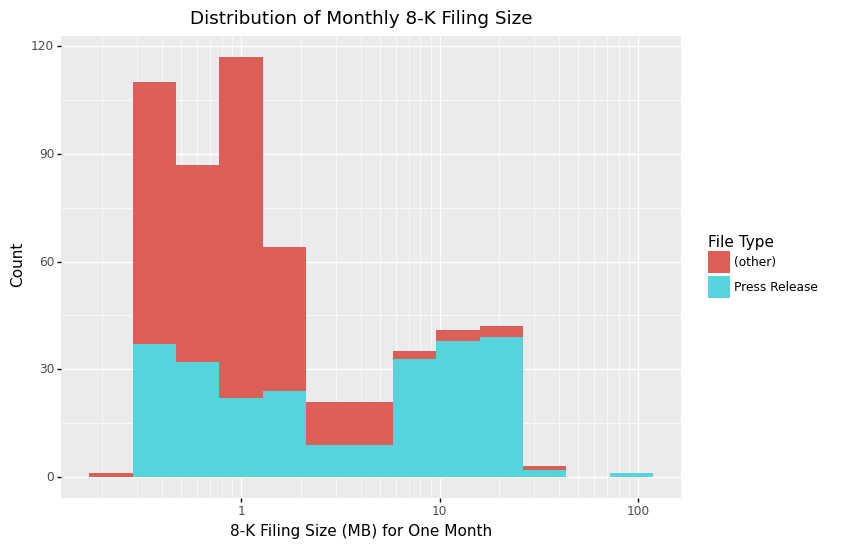

<ggplot: (8788370010519)>

In [85]:
df_file['filing_size'] = df_file['total_filing_size'] / 1000000
df_file['str_flag_99.1'] = '(other)'
df_file.loc[df_file['flag_99.1']==1, 'str_flag_99.1'] = 'Press Release'

(ggplot(df_file, aes(x='filing_size', y=after_stat('count'), fill='str_flag_99.1'))
    + geom_histogram()
    + labs(y='Count', x='8-K Filing Size (MB) for One Month', title='Distribution of Monthly 8-K Filing Size', fill='File Type')
    + scale_x_log10()
    + theme(figure_size=(8, 6))
)

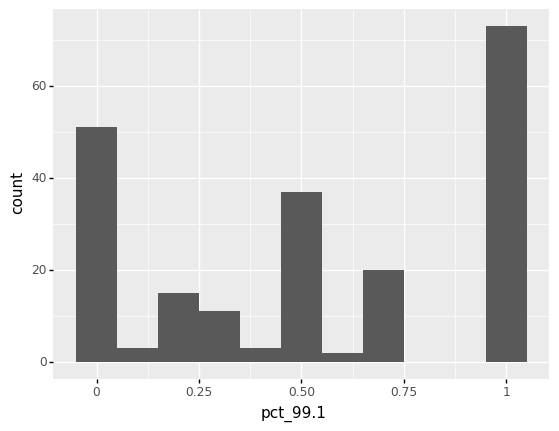

<ggplot: (8786050675014)>

In [312]:
(ggplot(df_cik, aes(x='pct_99.1', y=after_stat('count')))
    + geom_histogram(binwidth=0.1)
)

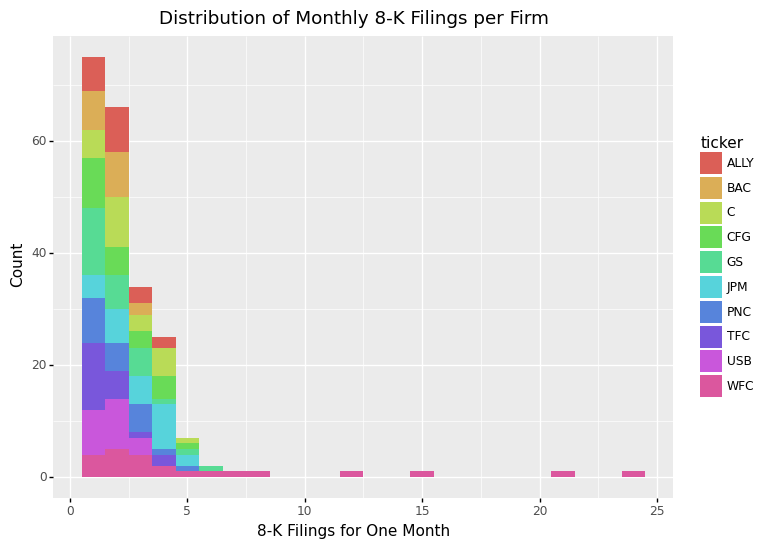

<ggplot: (8788386823852)>

In [58]:
(ggplot(df_cik, aes(x='total_file_count', y=after_stat('count'), fill='ticker'))
    + geom_histogram(binwidth=1)
    + labs(y='Count', x='8-K Filings for One Month', title='Distribution of Monthly 8-K Filings per Firm')
    + theme(figure_size=(8, 6))
)

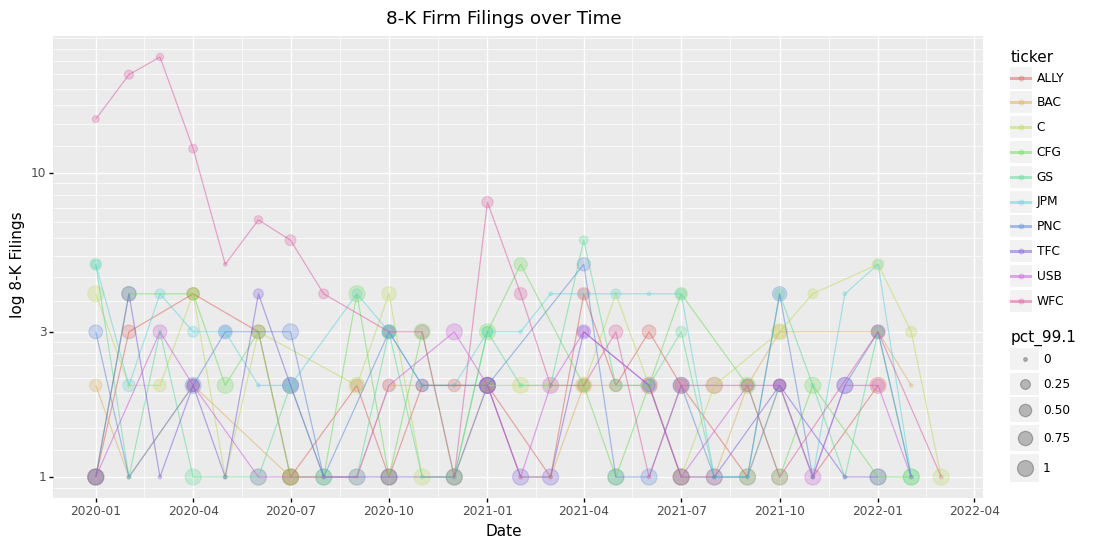

<ggplot: (8788393069273)>

In [45]:
(ggplot(aes(x='dt', y='total_file_count'), df_cik)
 + geom_point(aes(color='ticker', size='pct_99.1'), alpha=0.25) 
 + geom_line(aes(color='ticker'), alpha=0.5) 
 + scale_x_datetime(labels=date_format('%Y-%m')) 
 + scale_y_log10()
 + labs(y='log 8-K Filings', x='Date', title='8-K Firm Filings over Time')
 + theme(figure_size=(12, 6))
)

#### Compare with all documents (mis-leading)

This may be misleading because there are so many data (and other) documents for each Filing that they may not be comparable.

In [46]:
df = df_orig
df1 = df.query('file_type == "8-K"').groupby(['cik', 'yr-month']).size()
df2 = df.query('file_type == "8-K" and doc_type == "EX-99.1"').groupby(['cik', 'yr-month']).size()
df3 = df.query('file_type == "8-K" and doc_type == "EX-99.1"').groupby(['cik', 'yr-month']).sum('file_size')

In [47]:
#cik, month-yr, file_count, 99.1_count, sum_size_99.1_docs
df_tmp2 = df3
df_tmp2.rename(columns={'file_size':'99.1_file_size'}, inplace=True)
df_tmp2['8-K_count'] = df1
df_tmp2['99.1_count'] = df2

In [48]:
df_tmp2.reset_index(inplace=True)
df_tmp2['dt'] = pd.to_datetime(df_tmp2['yr-month'], format='%Y-%m')
df_tmp2['pct_99.1'] = df_tmp2['99.1_count'] / df_tmp2['8-K_count']

In [49]:
cik_tkr = [(str(bank.get_info()['cik']),bank.get_info()['ticker']) for bank in banks_uniq]
df_tmp1 = pd.DataFrame.from_records(cik_tkr, columns=['cik','ticker'])

In [50]:
df_tmp1['cik'] = df_tmp1['cik'].astype('str')
df_tmp2['cik'] = df_tmp2['cik'].astype('str')
df_summ = pd.merge(df_tmp2, df_tmp1, on='cik', how='left')

In [51]:
df_summ.head(3)

,cik,yr-month,99.1_file_size,8-K_count,99.1_count,dt,pct_99.1,ticker
0,19617,2020-1,265905,49,1,2020-01-01,0.020408,JPM
1,19617,2020-10,305680,31,2,2020-10-01,0.064516,JPM
2,19617,2020-2,3844,23,1,2020-02-01,0.043478,JPM


In [52]:
#! pip install plotnine

In [53]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

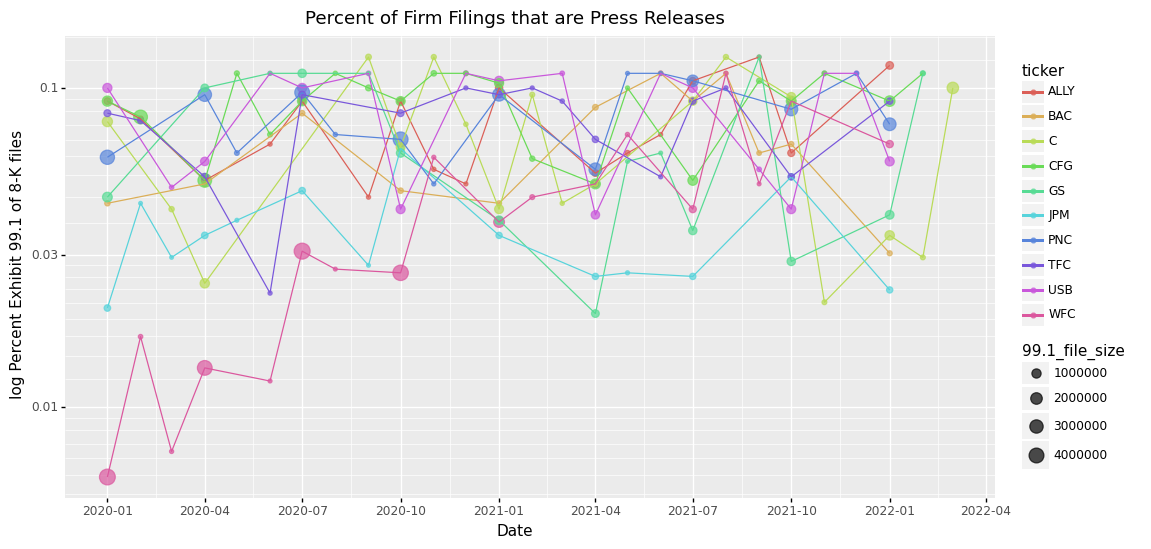

<ggplot: (8788393688254)>

In [54]:
(ggplot(aes(x='dt', y='pct_99.1'), df_summ)
 + geom_point(aes(color='ticker', size='99.1_file_size'), alpha=0.7) 
 + geom_line(aes(color='ticker')) 
 + scale_x_datetime(labels=date_format('%Y-%m')) 
 + scale_y_log10()
 + labs(y='log Percent Exhibit 99.1 of 8-K files', x='Date', title='Percent of Firm Filings that are Press Releases')
 + theme(figure_size=(12, 6))
)

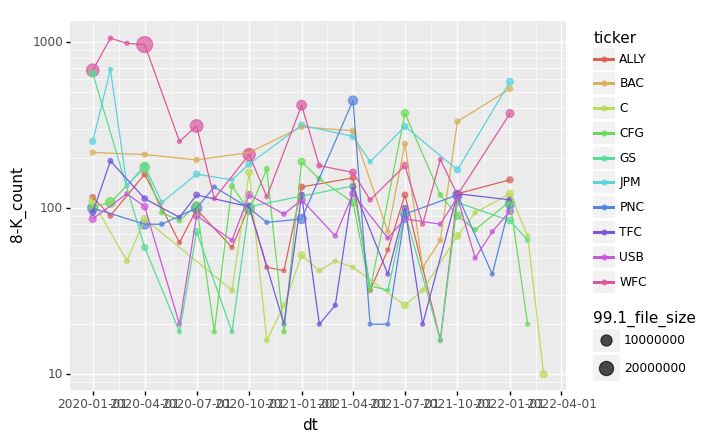

<ggplot: (8786090557666)>

In [40]:
p = ggplot(aes(x='dt', y='8-K_count'), df_summ)
p + geom_point(aes(color='ticker', size='99.1_file_size'), alpha=0.7) + geom_line(aes(color='ticker')) + scale_y_log10()

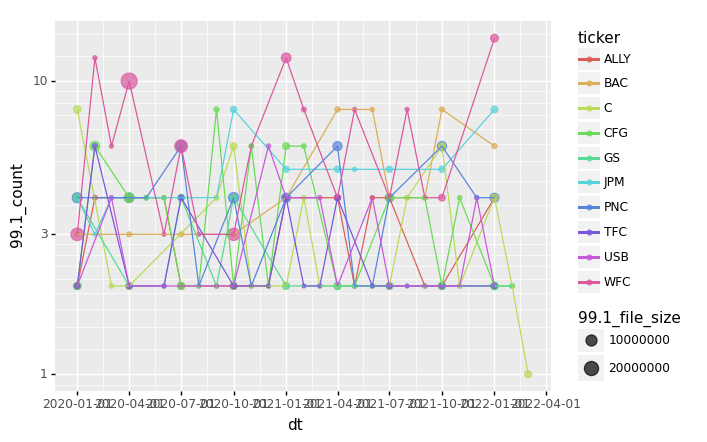

<ggplot: (8786089920759)>

In [41]:
p = ggplot(aes(x='dt', y='99.1_count'), df_summ)
p + geom_point(aes(color='ticker', size='99.1_file_size'), alpha=0.7) + geom_line(aes(color='ticker')) + scale_y_log10()

### Collectively review documents on the file system

In [64]:
os.chdir(libs_extract)
from sec_edgar_extractor import utils
os.chdir(root)

In [55]:
results1 = utils.search_docs_for_terms(download_folder = dl.download_folder, 
                                       search_list = [r'allowance for credit loss'], 
                                       ignore_case=True)    #, r'credit loss', r'ACL'

log: number of files matching criteria: 13 of 775
log: number of lines matching criteria: 34


In [56]:
results1[1]

{'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1043277/8-K/0001043277-20-000024/ex991earningsreleaseq1.htm',
 'index': 265068,
 'text': '0;&#160;&#160;&#160;&#160;Contract assets, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px',
 'start_format': 50,
 'end_format': 75}

In [57]:
START = 700
BATCH = 10
for rec in results1[START:START+BATCH]:
    print(rec['file'].split('/')[9], end='\t')
    utils.format_print(rec['text'], start=rec['start_format'], end=rec['end_format'])

In [73]:
results2 = utils.search_docs_for_terms(download_folder = dl.download_folder, 
                                       search_list = [r'Allowance for credit loss', r'credit loss', r'ACL'], 
                                       ignore_case=False)    #, r'credit loss', r'ACL'

log: number of files matching criteria: 58 of 775
log: number of lines matching criteria: 1136


In [74]:
START = 0
BATCH = 10
for rec in results2[START:START+BATCH]:
    print(rec['file'].split('/')[9], end='\t')
    utils.format_print(rec['text'], start=rec['start_format'], end=rec['end_format'])

ex991earningsreleaseq1.htm	160;&#160;&#160;Receivables, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px
ex991earningsreleaseq1.htm	&#160;&#160;Contract assets, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px
ex991earningsreleaseq1.htm	color:rgb(255,255,255, 0.0);">&#160;Provision for credit losses</font></td><td colspan="2" style="padding-top:2
ex991earningsreleaseq2.htm	160;&#160;&#160;Receivables, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px
ex991earningsreleaseq2.htm	&#160;&#160;Contract assets, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px
ex991earningsreleaseq2.htm	color:rgb(255,255,255, 0.0);">&#160;Provision for credit losses</font></td><td colspan="2" style="padding-top:2
ex991earningsreleaseq3.htm	160;&#160;&#160;Receivables, net of allowance for credit loss</font></td><td colspan="2" style="padding-top:2px
ex991earningsreleaseq3.htm	

In [75]:
unique_docs = list(set( [file['file'] for file in results2] ))
len(unique_docs)

58

In [76]:
unique_docs[:3]

['/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1043277/8-K/0001043277-21-000022/ex991earningsreleaseq20630.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/831001/8-K/0001104659-21-004454/c-20201221xex99d1.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000332/wfc3qer10-14x20ex991.htm']

## TODO: Data Analysis

This section tries different approaches to searching, filtering, and extracting the data.

### Prepare data

Find table that with high-probabilty of containing target.

In [240]:
#docs for bs4 speed improvement:  https://beautiful-soup-4.readthedocs.io/en/latest/#improving-performance
#! pip install cchardet
import cchardet
from bs4 import BeautifulSoup
import time

In [244]:
start_time = time.time()
table_lst = []
    
for doc in unique_docs:
    html_string = ()
    
    with open(doc) as f:
        html = f.read()
        soup = BeautifulSoup(html, 'lxml')
        tags = soup.find_all(text=re.compile('Total allowance for credit|Allowance for credit'))
        
        tbls = []
        for idx, tag in enumerate(tags):
            tbl = tag.find_parent('table')
            if tbl != None:
                tbls.append( {'idx': idx,
                              'cik': doc.split('/')[6],
                              'accension_number': doc.split('/')[8],
                              'url': doc,
                              'len': len(tbl),
                              'td_count': tbl.find_all('td').__len__(),
                              'string': tbl.prettify()
                             } 
                           )
        #rule-1: take largest table
        if len(tbls) > 0 and tbls != []:
            tbls_sorted = sorted(tbls, key=lambda x:x['len'], reverse=True)
            html_string = tbls_sorted[0]
        #rule-2: take table with most <td>
        if len(tbls) > 0 and tbls != []:
            tbls_sorted = sorted(tbls, key=lambda x:x['td_count'], reverse=True)
            html_string = tbls_sorted[0]
            
    if html_string != ():    
        df = pd.read_html(html_string['string'])[0]
        html_string['df'] = df
        table_lst.append(html_string)
        html_string = ()
print(f"log: execution took: {round(time.time() - start_time, 3)}sec")

log: execution took: 44.897sec


In [260]:
len(table_lst)

66

In [261]:
new_lst = sorted(table_lst, key=lambda x:x['cik'])

In [247]:
#[item['cik'] for item in new_lst]

In [248]:
tbl = new_lst[1]
print( tbl['idx'] )
print( tbl['cik'] )
print( tbl['accension_number'] )
print( tbl['url'] )
print( tbl['td_count'] )
print( tbl['string'][:100] )
#TODO:add page-number, table-number

1
1504008
0001504008-22-000003
/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-22-000003/earningsdocex99120211231.htm
765
<table style="border-collapse:collapse;display:inline-table;margin-bottom:5pt;vertical-align:text-bo


<br>
Prepare string output to a different format.  I don't remember why I did this :)

### Search-Extract

First, find where (what `<table>`) the account is in, then extract the account information.  This is a very parsimonious approach.


#### Search: Get account value from table


Now we have a list of unique 8-K, 99.1 (press releasees) that contain the terms we are inteterested.

For each document, extract the table most-likely to have the target accounts:

* open file
* find most-likely table
* separate html clip from total html file to reduce memory burden: SoupStrainer
* extract to df and add to list

#### Extract: Rule-based methods

This uses rule-based methods to parse the table from HTML to pd.DataFrame.  Unfortunately, this data is very messy both within and among Firm Filings.

from dateutil.parser import parse
import unicodedata

def if_date_convert(val, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    if type(val) == str:
        try:
            tmp = unicodedata.normalize('NFKD', val)
            dt = parse(tmp, fuzzy=fuzzy)
            return dt

        except ValueError:
            return string
    else:
        return val

In [182]:
def diff_consecutive_numbers(lst, key=False, cond=False):
    if not key:
        result = [lst[n+1] - lst[n] for n in range(len(lst)-1)]
    if key:
        result = [lst[n+1][key] - lst[n][key] for n in range(len(lst)-1)]
    if key and cond:
        result = [lst[n+1][key] - lst[n][key] for n in range(len(lst)-1) 
                  if lst[n+1][cond] == lst[n][cond]
                 ]
    return result

In [224]:
#! pip install pyahocorasick

In [225]:
import ahocorasick
import numpy as np

def check_strings(search_list, input):
    A = ahocorasick.Automaton()
    for idx, s in enumerate(search_list):
        A.add_word(s, (idx, s))
    A.make_automaton()

    index_list = []
    for item in A.iter(input):
        index_list.append(item[1][0])

    output_list = np.array([0] * len(search_list))
    output_list[index_list] = 1
    return output_list.tolist()

search_strings = ["hello", "world", "goodbye"]
test_string = "hello world"
print(check_strings(search_strings, test_string))

[1, 1, 0]


Steps to parse table:

0. look for units / scales
1. remove top rows with all NaN, remove columns that are all Nan
2. find headers by getting rows with first N columns with NaN
3. convert date strings to dates types
4. find section headers and group rows by sections
5. convert 

In [183]:
# 2
#(df1.loc[2].isnull()[0] == True) & (df1.loc[2].isnull().sum() < df1.shape[1])
#(df1.loc[3].isnull()[0] == True) & (df1.loc[3].isnull().sum() < df1.shape[1])

# 3
#df1.loc[3].apply(if_date_convert)

# 4
#(df1.loc[4].isnull()[0] == False) & (df1.loc[4].isnull()[1:] == True)

In [266]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,...,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,ALLOWANCE FOR CREDIT LOSSES,NaN
2,($ in millions),NaN,3Q,3Q,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3Q,3Q,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2020,2020,NaN,NaN,% (a),% (a),NaN,NaN,...,% (a),NaN,NaN,2019,2019,NaN,NaN,% (a),% (a),NaN
4,"Balance, beginning of period",NaN,NaN,"$7,890",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"$4,466",NaN,NaN,NaN,NaN,NaN


In [265]:
#0.look for units
#TODO:add logic if more than one unit found
search_strings = ["thousand", "million", "billion"]
print(check_strings(search_strings, df_string))

[0, 1, 0]


In [267]:
#1.remove where all na
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

In [268]:
#2. find header / formatting rows
#use the 'missing square'
rows, cols = df.shape

format_rows = []   #list(df.index[df.isna().any(axis=1)])
format_cols = []   #df.columns[df.isna().any()].tolist()

header_rows = []
format_not_hdr_rows = []


for row in range(rows):
    if df.loc[row].isnull().sum() < cols:
        
        #where are there missing values
        na_index = []
        for col in range(cols):
            if pd.isna(df.loc[row,col])==True: 
                na_index.append(col)
                
        #where are consecutive missing values
        cond1 = na_index[0] == 0
        cond2 = len(na_index) > 1
        if cond1 and not cond2: 
            format_rows.append( {'row': row,
                                 'start': 0,
                                 'na_idx': [0]
                                })
        if cond1 and cond2:  
            tmp_diff = diff_consecutive_numbers(na_index)
            group_index = [idx for idx,item in enumerate(tmp_diff) if item > 1]
            format_rows.append( {'row': row,
                                 'start': group_index[0],
                                 'na_idx': na_index
                                })
            
#where are consecutive rows that meet criterion            
tmp_diff = diff_consecutive_numbers(format_rows, key='row', cond='start')
tmp_consecutives = [idx for idx,item in enumerate(tmp_diff) if item > 1]
if len(tmp_consecutives) > 0:
    last_hdr_row = tmp_consecutives[0] + 1
else:
    last_hdr_row = len(format_rows)
header_rows.extend( format_rows[:last_hdr_row] )
other_idx = set( [row['row'] for row in format_rows] ) - set( [row['row'] for row in header_rows] )
format_not_hdr_rows.extend( [row for row in format_rows if row['row'] in other_idx] )

#where is the index column

In [269]:
na_index

[40]

In [270]:
header_rows

[{'row': 2,
  'start': 1,
  'na_idx': [0,
   1,
   4,
   5,
   8,
   9,
   12,
   13,
   16,
   17,
   20,
   21,
   24,
   25,
   28,
   29,
   32,
   33,
   36,
   37,
   40]}]

In [271]:
format_not_hdr_rows

[]

In [272]:
idx_hdr = [row['row'] for row in header_rows]
#df.drop(index=[idx_hdr])
df.loc[idx_hdr,1:]

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
2,NaN,2020,2020,NaN,NaN,% (a),% (a),NaN,NaN,2020,...,% (a),NaN,NaN,2019,2019,NaN,NaN,% (a),% (a),NaN


### Extract-Search

Take the 8-K `.htm` file and extract all tabular data in the document.  Then search for the account values.

#### Extract

We convert to .pdf file because tabular information extraction focuses on data in image of .pdf files.

HTML => PDF => OCR => DF

```
#ref: https://pypi.org/project/wkhtmltopdf/
#Install Xvfd:
sudo apt-get install xvfb
#Install Fonts:
sudo apt-get install xfonts-100dpi xfonts-75dpi xfonts-scalable xfonts-cyrillic
#Install wkhtmltopdf:
sudo apt-get install wkhtmltopdf
#Install flashplugin:
sudo apt-get install flashplugin-nonfree
```

In [673]:
#! pip install py3-wkhtmltopdf

In [689]:
#conda install -c conda-forge camelot-py

__Lattice__

In [137]:
! ls /home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/

d36659dex991.htm  d36659dex991.htm-modified.pdf  d36659dex991.htm.pdf


In [138]:
import camelot

input_file_path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/d36659dex991.htm-modified.pdf'
tables = camelot.read_pdf(input_file_path, flavor='lattice')
tables

<TableList n=1>

In [139]:
tables[0].df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,ALLOWANCE\tFOR\tCREDIT\tLOSSES,,,,,,,,,,...,,,,,,,,,,
1,($\tin\tmillions)\n3Q\n2Q\n1Q\n4Q\n3Q\n2020\n%...,,,,,,,,,,...,,,,,,,,,,
2,"Balance,\tbeginning\tof\tperiod",,"$7,890",,,,,"$6,590",,,...,,"$4,481",,,,,"$4,466",,,
3,Change\tin\taccounting\tprinciple\t(b),,--,,,,,--,,,...,,--,,,,,--,,,
4,Net\tcharge-offs,,,,,,,,,,...,,,,,,,,,,
5,Commercial,,167,,.60,,,105,,.34,...,,74,,.30,,,72,,.29,
6,Lease\tfinancing,,11,,.78,,,6,,.43,...,,4,,.29,,,3,,.22,
7,Total\tcommercial,,178,,.61,,,111,,.35,...,,78,,.30,,,75,,.29,
8,Commercial\tmortgages,,85,,1.13,,,19,,.25,...,,7,,.10,,,3,,.04,
9,Construction\tand\tdevelopment,,(2),,,(.07),,3,,.11,...,,--,,--,,,3,,.11,


__Stream__

In [86]:
from wkhtmltopdf import WKHtmlToPdf

wkhtmltopdf = WKHtmlToPdf(
    url='https://www.sec.gov/Archives/edgar/data/36104/000119312520268950/d36659dex991.htm',
    output_file='/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/d36659dex991.htm.pdf',
)
wkhtmltopdf.render()

_XSERVTransmkdir: Owner of /tmp/.X11-unix should be set to root


In [87]:
! ls /home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/

d36659dex991.htm  d36659dex991.htm.pdf


__Note:__ you must use the `flavor=stream` argument with these files

In [88]:
import camelot

input_file_path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/d36659dex991.htm.pdf'
output_file_path = '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950/tmp.csv'

tables = camelot.read_pdf(input_file_path, flavor='stream', pages='9', column_tol=10)
tables

<TableList n=1>

In [292]:
#help(camelot.read_pdf)

In [215]:
tables.export(output_file_path, f='csv', compress=False) # json, excel, html, markdown, sqlite

In [283]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

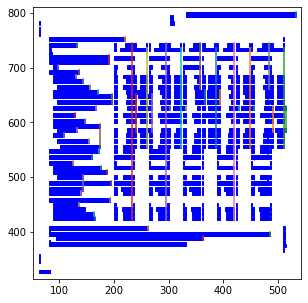

In [303]:
camelot.plot(tables[0], kind='textedge').show()

In [89]:
IDX = 0
print( tables[IDX].parsing_report )
#tables[IDX].to_csv('foo.csv') # to_json, to_excel, to_html, to_markdown, to_sqlite
tables[IDX].df # get a pandas DataFrame!

{'accuracy': 96.94, 'whitespace': 30.61, 'order': 1, 'page': 9}


,0,1,2,3,4,5,6
0,ALLOWANCE\tFOR\tCREDIT\tLOSSES,,,,,,
1,($\tin\tmillions),,3Q,2Q,1Q,4Q,3Q
2,,,2020\t\n\t %\t(a),2020\t\n\t %\t(a),2020\t\n\t %\t(a),2019\t\n\t %\t(a),2019\t\n\t %\t(a)
3,B,"alance,\tbeginning\tof\tperiod","$7,890","$6,590","$4,491","$4,481","$4,466"
4,Change\tin\taccounting\tprinciple,,,,,,
5,,(b),--,--,"1,499",--,--
6,Net\tcharge-offs,,,,,,
7,,Commercial,167\t\n\t \t\n.60,105\t\n\t \t\n.34,69\t\n\t \t\n.28,74\t\n\t \t\n.30,72\t\n\t \t\n.29
8,,Lease\tfinancing,11\t\n\t \t\n.78,6\t\n\t \t\n.43,5\t\n\t \t\n.36,4\t\n\t \t\n.29,3\t\n\t \t\n.22
9,,Total\tcommercial,178\t\n\t \t\n.61,111\t\n\t \t\n.35,74\t\n\t \t\n.28,78\t\n\t \t\n.30,75\t\n\t \t\n.29


In [90]:
df = tables[IDX].df

In [97]:
df.loc[:,0]

0            ALLOWANCE\tFOR\tCREDIT\tLOSSES
1                         ($\tin\tmillions)
2                                          
3                                         B
4         Change\tin\taccounting\tprinciple
5                                          
6                          Net\tcharge-offs
7                                          
8                                          
9                                          
10                                         
11                                         
12                                         
13                                         
14                                         
15                                         
16                                         
17                                         
18                                         
19                                         
20                                         
21           Provision\tfor\tcredit\tlosses
22                Balance,\tend\

<br>
<br>
<br>
<br>

## Workflow

Initial Steps:

* ~~get data for all banks in excel file~~
* ~~get proper url list that removes all non-banks~~
* ~~in the tables obtained from camelot (above^^^), find one that has the target term 'Allowance for credit loss'~~
* ~~take that table use the DF export~~
* take that DF and use rule-based methods to get: headers, index, units/scale, context/section
* extract the target term programmatically


Larger Plan:

* do one table
* do with additional tables from same firm
* do with 10-Q extracts
* do with additional firms
* ...


Aspects that need improvement:

* find documents that contain information: `search_docs_for_terms() => unique_docs`
* find the correct table in the document: process to get `table_lst` / `new_lst`
* parse table: cv and rules to get df
* query table: get account value

__Preparatory Work__:

* Data Exploration / Review documents (visually)
* Data Analysis / Prepare data

__Step-0:__ only create backups when necessary

In [21]:
with open(path_banks, 'wb') as File:
            pickle.dump(banks_uniq, File, protocol=4)

In [265]:
with open(path_new_lst, 'wb') as File:
            pickle.dump(new_lst, File, protocol=4)

__Step-1:__ prepare the environment, and get the index (IDX) for the banks

In [266]:
import os

In [267]:
root = os.getcwd()
libs = './python_modules/Prj-sec_workflows'

In [268]:
! pwd

/home/jovyan/NOTEBOOK_PUBLIC


In [269]:
os.chdir(libs)
from sec_api.Accession import AccessionNumber
from sec_api.Firm import Firm
from sec_api.Filing import Filing
os.chdir(root)

In [270]:
from pathlib import Path
import pickle

from bs4 import BeautifulSoup
from wkhtmltopdf import WKHtmlToPdf
import pdfkit
import camelot

In [271]:
# not used currently
#check = pdfkit.from_string(str(soup), path_html)

In [272]:
path_sec = Path.cwd() / 'large_dataset' / 'sec-edgar-filings'
path_banks = path_sec / 'banks.pickle'
path_new_lst = path_sec / 'new_lst.pickle'

In [273]:
with open(path_banks, 'rb') as File:
            banks_uniq = pickle.load(File)

In [274]:
with open(path_new_lst, 'rb') as File:
            new_lst = pickle.load(File)

In [288]:
[print(f"{bank.get_info()['ticker']}: {bank.get_info()['cik']}") for bank in banks_uniq]

JPM: 19617
C: 831001
WFC: 72971
BAC: 70858
USB: 36104
PNC: 713676
GS: 886982
TFC: 92230
ALLY: 40729
CFG: 759944


[None, None, None, None, None, None, None, None, None, None]

In [276]:
banks_uniq_cik = [str(bank.get_info()['cik']) for bank in banks_uniq]
[idx for idx,item in enumerate(new_lst) if item['cik'] in banks_uniq_cik]
[item['url'] for item in new_lst]  
#get items: 1(36104), 10(713676)X, 13(72971), 20(759944), 22(831001)X, 23(WFC)
#get items: 

['/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1283699/8-K/0001283699-20-000112/sprintcorp201910-k.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-22-000003/earningsdocex99120211231.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-20-000017/earningsdoc99120200331.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-21-000003/earningsdocex99120201231.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-21-000013/earningsdocex99120210331.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-21-000022/earningsdocex99120210630.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-20-000025/earningsdoc99120200630.htm',
 '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/1504008/8-K/0001504008-21-000028/earningsdocex99120210930.

__Step-2:__ manually loop through the list to get each DF

In [459]:
IDX = 65      #<<<< CHANGE

cik = new_lst[IDX]['cik']
accession = new_lst[IDX]['accension_number']
file_name = new_lst[IDX]['url'].split('/')[9].split('.')[0]
file_extension = new_lst[IDX]['url'].split('/')[9].split('.')[1]
soup = BeautifulSoup(new_lst[IDX]['string'], "html5lib")

In [460]:
path_base = Path(f'/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/{ cik }/8-K/{ accession }/')
path_html = path_base / (file_name + '-table.htm')
path_pdf = path_base / (file_name + '-table.pdf')

In [461]:
path_base

PosixPath('/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/831001/8-K/0001104659-22-028867')

In [462]:
with open(path_html, 'w') as file:
    file.write(str(soup))

In [463]:
wkhtmltopdf = WKHtmlToPdf(url = path_html,
                          output_file = path_pdf
                         )
wkhtmltopdf.render()

(EE) 
Fatal server error:
(EE) Server is already active for display 0
	If this server is no longer running, remove /tmp/.X0-lock
	and start again.
(EE) 


In [464]:
#[x for x in path_base.iterdir() if x.is_file()]

In [465]:
tables = camelot.read_pdf(str(path_pdf), flavor='stream', pages='1-end', column_tol=10)
tables

<TableList n=1>

In [466]:
tables[0].df

,0,1,2,3,4,5,6,7
0,,,,,,,,4Q21Â\tIncrease/
1,,,"DecemberÂ\t31,","DecemberÂ\t31,","DecemberÂ\t31,","DecemberÂ\t31,","DecemberÂ\t31,",(Decrease)Â\tfrom
2,,,2017,2018,2019,2020,2021,4Q20
3,Assets,,,,,,,
4,,,"23,775","23,645","23,967","26,349","27,515",
...,...,...,...,...,...,...,...,...
90,Noncontrolling\tinterests,,,,,,,(8%)
91,,,"201,672","197,074","193,946","200,200","202,672",
92,Total\tequity,,,,,,,1%
93,,,"1,842,465","1,917,383","1,951,158","2,260,090","2,291,413",


In [488]:
results = []

In [468]:
path_base

PosixPath('/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/831001/8-K/0001104659-22-028867')

### Notes

Tables rendered poorly:
    
'large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000230' 
'large_dataset/sec-edgar-filings/831001/8-K/0001104659-22-028867'

Difficult or interesting tables

'large_dataset/sec-edgar-filings/713676/8-K/0000713676-21-000109/q32021financialhighlightsa.htm'
'large_dataset/sec-edgar-filings/759944/8-K/0001193125-20-270685/d163450dex991.htm'
'large_dataset/sec-edgar-filings/759944/8-K/0001193125-21-011878/d284440dex991.htm'

Terms difficult to disambiguate:
    
* 'Allowance for credit losses for loans'
* 'Total allowance for credit losses for debt securities'
* 'Held-to-maturity, at amortized cost, net of allowance for credit losses'
* 'Available-for-sale, at fair value (includes allowance for credit losses)'
* 'Allocation of the Allowance for Credit Losses for Loans'
* 

Unstructured text containing information:

* 'Allowance for credit losses for loans of $20.5 billion, flat compared with second quarter 2020'

In [478]:
from rapidfuzz import process, fuzz

def get_best_guess(df, term='Total allowance for credit losses', display_terms=3, index_term=0):
    lst = df.loc[:,0].to_list()
    idx_term = process.extract(term, lst, scorer=fuzz.WRatio, limit=display_terms)
    print(idx_term)
    idx = df.loc[:,0].to_list().index(idx_term[index_term][0])
    return df.loc[idx][2]

In [377]:
# 713676
df = tables[0].df
    #terms = ['Allowance\tfor\tcredit\tlosses', 'Allowance\tfor\tloan\tand\tlease\tlosses\t(b)', 'Allowance\tfor\tloan\tand\tlease\tlosses']
lst = df.loc[:,0].to_list()
term = process.extract('Allowance for credit losses', lst, scorer=fuzz.WRatio)

idx = df.loc[:,0].to_list().index(term[0])
df.loc[idx][2]

#idx = df.loc[:,0].to_list().index('Allowance\tfor\tloan\tand\tlease\tlosses\t(b)')
#df.loc[idx][2]

'646'

In [489]:
#TODO:these are incorrect, look in table 'Credit Quality' for correct value
cik = '713676'
ticker = 'PNC'

results.append( {'cik':cik, 'ticker':ticker, 'acl': '5,530', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/713676/8-K/0000713676-22-000007'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '3,944', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/713676/8-K/0000713676-20-000068'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '5,361', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/713676/8-K/0000713676-21-000011'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '4,868', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/713676/8-K/0000713676-22-000005'} )


In [ ]:
# 36104
df = tables[0].df
idx = df.loc[:,0].to_list().index('Total\tallowance\tfor\tcredit\tlosses')
df.loc[idx][1]

In [490]:
cik = '36104'
ticker = 'USB'

results.append( {'cik':cik, 'ticker':ticker, 'acl': '$8,010', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$6,960', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-21-117074'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$6,590', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-107589'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$4,491', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-007601'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$8,010', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-21-011887'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$6,300', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-21-298251'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$6,155', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-22-011895'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$6,610', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-21-215777'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$7,890', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-192926'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '$8,010', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/36104/8-K/0001193125-20-268950'} )


In [455]:
# 72971
df = tables[0].df
idx = df.loc[:,0].to_list().index('Allowance\tfor\tcredit\tlosses\tfor\tloans')    #'Total\tallowance\tfor\tcredit\tlosses\tfor\tdebt\tsecurities')
df.loc[idx][2]

'18,043'

In [456]:
get_best_guess(tables[0].df)

'0.24%'

In [491]:
cik = '72971'
ticker = 'WFC'

results.append( {'cik':cik, 'ticker':ticker, 'acl': '105', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000332'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '134', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000280'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '172', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000230'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '8,728', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000230'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '(223)', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000011'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '13,788', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-22-000003'} )
results.append( {'cik':cik, 'ticker':ticker, 'acl': '18,043', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/72971/8-K/0000072971-21-000206'} )


In [84]:
# 759944
df = tables[0].df
idx = df.loc[:,0].to_list().index('Total\tallowance\tfor\tcredit\tlosses')
df.loc[idx][1].split('\n')[0]

'$2,210'

In [492]:
cik = '759944'
ticker = 'CFG'

results.append( {'cik':cik, 'ticker':ticker, 'acl': '$2,210', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/759944/8-K/0001193125-20-120372'} )


In [ ]:
# 831001
df = tables[0].df
idx = df.loc[:,0].to_list().index('Allowance\tfor\tcredit\tlosses\ton\tloans\t(ACLL)')
df.loc[idx][1].split('\n')[0]

In [486]:
get_best_guess(tables[0].df, term='allowance for credit loss', display_terms=3, index_term=0)

[('Allowance\tfor\tcredit\tlosses\ton\tloans\t(ACLL)', 90.0, 31), ('Securities\tborrowed\tand\tpurchased\tunder\tagreements\tto\tresell,\tnet\tof\tallowance', 85.5, 9), ('Brokerage\treceivables,\tnet\tof\tallowance', 85.5, 11)]


''

In [493]:
cik = '831001'
ticker = 'C'

results.append( {'cik':cik, 'ticker':ticker, 'acl': '$2,210', 'file': '/home/jovyan/NOTEBOOK_PUBLIC/large_dataset/sec-edgar-filings/831001/8-K/0001104659-22-028867'} )


In [214]:
#[bank.get_info() for bank in banks_uniq]

In [494]:
import pandas as pd
df_tmp = pd.DataFrame.from_dict(results)
df_tmp.columns = ['CIK', 'TICKER', 'ACL', 'file']
df_tmp['Units'] = 'millions'
df_tmp['Year'] = '20' + df_tmp.apply(lambda row: row['file'].split('/')[8].split('-')[1], axis=1)
df_tmp['Accession'] = df_tmp.apply(lambda row: row['file'].split('/')[8], axis=1)
df_tmp.drop(columns='file', inplace=True)

In [495]:
files = dl.filing_storage.get_list()
acc_nos = df_tmp['Accession'].to_list()

files_selected = [{'cik':file.short_cik, 
                   'acc_no': file.accession_number.get_accession_number(), 
                   'file_date': file.file_date
                  } for file in files if file.accession_number.get_accession_number() in acc_nos]
df_qtr = pd.DataFrame.from_dict(files_selected)
df_qtr['qtr'] = df_qtr.apply(lambda row: row['file_date'].quarter, axis=1)
df_qtr.drop_duplicates(['cik','acc_no'], inplace=True)

df_present = df_tmp.merge(df_qtr, how='left', left_on='Accession', right_on='acc_no')
df_present['Period'] = df_present['Year'] + '-' + df_present['qtr'].astype(str)
df_present.drop(columns=['cik','acc_no','Year','qtr'], inplace=True)


In [496]:
df_present.sort_values(by=['CIK','file_date'], axis=0)

,CIK,TICKER,ACL,Units,Accession,file_date,Period
7,36104,USB,"$4,491",millions,0001193125-20-007601,2020-01-15,2020-1
6,36104,USB,"$6,590",millions,0001193125-20-107589,2020-04-15,2020-2
12,36104,USB,"$7,890",millions,0001193125-20-192926,2020-07-15,2020-3
4,36104,USB,"$8,010",millions,0001193125-20-268950,2020-10-14,2020-4
13,36104,USB,"$8,010",millions,0001193125-20-268950,2020-10-14,2020-4
8,36104,USB,"$8,010",millions,0001193125-21-011887,2021-01-20,2021-1
5,36104,USB,"$6,960",millions,0001193125-21-117074,2021-04-15,2021-2
11,36104,USB,"$6,610",millions,0001193125-21-215777,2021-07-15,2021-3
9,36104,USB,"$6,300",millions,0001193125-21-298251,2021-10-14,2021-4
10,36104,USB,"$6,155",millions,0001193125-22-011895,2022-01-19,2022-1


In [498]:
path_output = Path.cwd() / 'large_dataset' / 'table_output.csv'
df_present.to_csv(path_output)

## Notes

Tables rendered poorly:
    
* `large_dataset/sec-edgar-filings/72971/8-K/0000072971-20-000230`
* `large_dataset/sec-edgar-filings/831001/8-K/0001104659-22-028867`

Difficult or interesting tables:

* `large_dataset/sec-edgar-filings/713676/8-K/0000713676-21-000109/q32021financialhighlightsa.htm`
* `large_dataset/sec-edgar-filings/759944/8-K/0001193125-20-270685/d163450dex991.htm`
* `large_dataset/sec-edgar-filings/759944/8-K/0001193125-21-011878/d284440dex991.htm`

Terms difficult to disambiguate:
    
* 'Allowance for credit losses for loans'
* 'Total allowance for credit losses for debt securities'
* 'Held-to-maturity, at amortized cost, net of allowance for credit losses'
* 'Available-for-sale, at fair value (includes allowance for credit losses)'
* 'Allocation of the Allowance for Credit Losses for Loans'
* ...

Unstructured text containing information:

* 'Allowance for credit losses for loans of $20.5 billion, flat compared with second quarter 2020'


Notes for each bank:

* USB
  - appears good
* PNC 
  - extracts are incorrect, they are for 'Allowance for loan and lease losses', ACL only mentioned in unstructured text.
  - tables not extracted because no mention of ACL (press release for acquisition or sell), only images within html available (image file available), and because of errors 
  - error (0000713676-20-000070): $3,944
  - found but unstructured (0000713676-20-000096): 'The allowance for credit losses increased to $6.6 billion, or 2.55% of total loans, at'
  - table in image format (000071367620000117)
  - PCL reported but not ACL
* WFC
  - correct (0000072971-21-000206): $18,043
  - provides table (0000072971-20-000230): 'FIVE QUARTER CHANGES IN ALLOWANCE FOR CREDIT LOSSES FOR LOANS', so only 'Balance' is available in index
  - provides table (0000072971-20-000011): 'CHANGES IN ALLOWANCE FOR CREDIT LOSSES'
  - uses ACL and 'Allowance for credit losses for loans' interchangeably
* CFG
  - correct (0001193125-20-120372): $2,210
  - many, many ppt images in html
  - unstructured (0001193125-20-194409): 'increase in the allowance for credit losses results in a June 30, 2020 allowance for credit losses (“ACL”) of $2.5 billion and an ACL to loans ratio of 2.01%'
  - structured (0001193125-20-194409): 2,527
  - structured (0000759944-21-000049): 2,372
* C
  - incorrect (0001104659-22-028867): Allowance for credit losses on loans (ACLL): (12,355)
  - some EX-99.1 can be iXBRL!!! example (000141057822000010)
  - unstructured (0001104659-22-004263): 'Citigroup’s allowance for credit losses on loans was $16.5 billion at quarter end, or 2.49% of total loans, compared to $25.0 billion, or 3.73% of total loans'
  - structured (0001104659-22-004263): 